In [6]:
import pandas as pd
from langchain_core.documents import Document as LangchainDocument
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from sentence_transformers import SentenceTransformer
from transformers import (
    Pipeline,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForQuestionAnswering,
    BitsAndBytesConfig,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
)

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Optional
import pickle

In [24]:
train_data = pd.read_json("../qa/wikipedia-train.json")

# Split the data: first 1000 questions for dev
validation_data = train_data.iloc[:7900]

# Split the data: first 300 questions for final test
test_data= pd.read_json("../qa/wikipedia-dev.json")


In [25]:
print(f"Training set size: {len(validation_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 7900
Test set size: 7993


In [26]:
validation_data.head(3)

,Data,Domain,Split,VerifiedEval,Version
0,"{'Answer': {'Aliases': ['Park Grove (1895)', '...",Wikipedia,train,False,1
1,"{'Answer': {'Aliases': ['Portogało', 'Republic...",Wikipedia,train,False,1
2,"{'Answer': {'Aliases': ['Chi-Beria', 'Sayre la...",Wikipedia,train,False,1


In [27]:
#Build a list of docs from the downloaded Wikipedia documents
def getDocs(examples):
    # List of docs
    docs = []
    # Extracting metadata and filenames from the examples (training data)
    for example in examples["Data"]:
        filename = example["EntityPages"][0]["Filename"]
        with open(f"..//evidence/wikipedia/{filename}", "r") as file:
            context_text = file.read()
        # Create a Document for RAG
        newDoc = LangchainDocument(
                metadata={
                    'question_id': example['QuestionId'],
                    'source': example['EntityPages'][0]['DocSource'],
                    'answer_type': example['Answer']['Type'],
                    'entity_name': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'aliases': example['Answer'].get('Aliases', []), # Default to empty list if missing
                    'normalized_value': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'filename': example['EntityPages'][0]['Filename'],
                },
                page_content=context_text
        )
        docs.append(newDoc)
    return docs

In [28]:
validation_data["Data"].iloc[0]["EntityPages"]

[{'DocSource': 'TagMe', 'Filename': 'England.txt', 'Title': 'England'},
 {'DocSource': 'TagMe', 'Filename': 'Judi_Dench.txt', 'Title': 'Judi Dench'}]

In [29]:
RAW_KNOWLEDGE_BASE = getDocs(validation_data)

In [37]:
# Function to split the documents into chunks with TQDM progress bars
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    Shows progress using TQDM.
    """
    print("Loading tokenizer...")
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    print(f"Tokenizer loaded in {time.time() - start_time:.2f} seconds")
    
    TRIVIAQA_SEPARATORS = [
        "\n\n",  # Paragraph breaks
        "\n",    # Line breaks
        ". ",    # Sentences
        "? ",    # Questions
        "! ",    # Exclamations
        "; ",    # Semicolons
        ": ",    # Colons
        ", ",    # Commas
        " ",     # Words
        ""       # Characters
    ]
    
    print("Creating text splitter...")
    start_time = time.time()
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TRIVIAQA_SEPARATORS,
    )
    print(f"Text splitter created in {time.time() - start_time:.2f} seconds")
    
    docs_processed = []
    print(f"Processing {len(knowledge_base)} documents...")
    
    # Using tqdm to show progress
    for doc in tqdm(knowledge_base, desc="Splitting documents"):
        chunks = text_splitter.split_documents([doc])
        docs_processed.extend(chunks)
    
    print(f"Created {len(docs_processed)} chunks from {len(knowledge_base)} documents")
    
    # Remove duplicates with progress bar
    print("Removing duplicates...")
    start_time = time.time()
    unique_texts = {}
    docs_processed_unique = []
    
    for doc in tqdm(docs_processed, desc="Removing duplicates"):
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)
    
    print(f"Removed {len(docs_processed) - len(docs_processed_unique)} duplicate chunks in {time.time() - start_time:.2f} seconds")
    print(f"Final document count: {len(docs_processed_unique)} chunks")
    
    return docs_processed_unique

# Processing the RAW_KNOWLEDGE_BASE (validation_data)
print("Starting document processing...")
overall_start_time = time.time()

docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)



Starting document processing...
Loading tokenizer...
Tokenizer loaded in 0.10 seconds
Creating text splitter...
Text splitter created in 0.00 seconds
Processing 7900 documents...


Splitting documents:   0%|          | 0/7900 [00:00<?, ?it/s]

Created 125208 chunks from 7900 documents
Removing duplicates...


Removing duplicates:   0%|          | 0/125208 [00:00<?, ?it/s]

Removed 50025 duplicate chunks in 0.20 seconds
Final document count: 75183 chunks


  0%|          | 0/75183 [00:00<?, ?it/s]

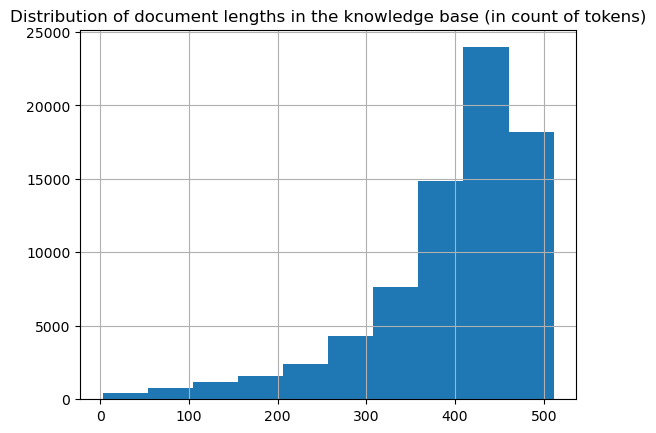

In [41]:
with open("docs_processed.pkl", "wb") as file:
    pickle.dump(docs_processed, file)
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [40]:
# The total number of chunks we have
len(docs_processed)

75183

In [4]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [63]:
# only run once and save the faiss db
#KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE)

In [57]:
#faiss_index_path = "knowledge_vector_database-validation"
#KNOWLEDGE_VECTOR_DATABASE.save_local(faiss_index_path)

In [58]:
# taotal length of the chunks stored in this vector db
#print(len(KNOWLEDGE_VECTOR_DATABASE.docstore._dict))

75183


In [10]:
# Load the pre-created vector database
faiss_index_path = "knowledge_vector_database-validation"
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local(faiss_index_path, embedding_model, allow_dangerous_deserialization=True)

In [11]:
# Get all docstore IDs
doc_ids = list(KNOWLEDGE_VECTOR_DATABASE.docstore._dict.keys())
print(f"Total documents: {len(doc_ids)}")

# Pick one document ID (e.g., first)
doc_id = doc_ids[0]
doc = KNOWLEDGE_VECTOR_DATABASE.docstore._dict[doc_id]

print("Sample chunk text:")
print(doc.page_content)

Total documents: 75183
Sample chunk text:
England is a country that is part of the United Kingdom.   It shares land borders with Scotland to the north and Wales to the west. The Irish Sea lies northwest of England and the Celtic Sea lies to the southwest. England is separated from continental Europe by the North Sea to the east and the English Channel to the south. The country covers much of the central and southern part of the island of Great Britain, which lies in the North Atlantic; and includes over 100 smaller islands such as the Isles of Scilly, and the Isle of Wight.

The area now called England was first inhabited by modern humans during the Upper Palaeolithic period, but takes its name from the Angles, one of the Germanic tribes who settled during the 5th and 6th centuries. England became a unified state in the 10th century, and since the Age of Discovery, which began during the 15th century, has had a significant cultural and legal impact on the wider world.  The English lang

In [12]:
vector = KNOWLEDGE_VECTOR_DATABASE.index.reconstruct(0)  # 0 = first chunk

print("Embedding vector (first 10 values):")
print(vector[:10])  # just show the first 10 dimensions
print("Vector dimension:", len(vector))

Embedding vector (first 10 values):
[ 0.00019079 -0.02058171  0.0605572  -0.04565329  0.05302824  0.01984793
  0.05352763  0.01497101  0.01897604 -0.01272711]
Vector dimension: 384


In [13]:
user_query = "Which Mediterranean island was once known as Alashiya?"
query_vector = embedding_model.embed_query(user_query)

In [14]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top 1 document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)
print(
    "\n==================================Top 2 document=================================="
)
print(retrieved_docs[1].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[1].metadata)


Starting retrieval for user_query='Which Mediterranean island was once known as Alashiya?'...

==================================Top 1 document==================================
The Balearic Islands (; ;    ) are an archipelago of Spain in the western Mediterranean Sea, near the eastern coast of the Iberian Peninsula.

The four largest islands are Majorca, Minorca, Ibiza and Formentera. There are many minor islands and islets close to the larger islands, including Cabrera, Dragonera and S'Espalmador. The islands have a Mediterranean climate, and the four major islands are all popular tourist destinations. Ibiza in particular is known as an international party destination, attracting many of the world's most popular DJs to its nightclubs.  The islands' culture and cuisine are similar to that of the rest of Spain.

The archipelago forms an autonomous community and a province of Spain, with Palma de Mallorca as the capital. The 2007 Statute of Autonomy declares the Balearic Islands as on

In [1]:
from vllm import LLM, SamplingParams

INFO 04-03 19:43:06 [__init__.py:239] Automatically detected platform cuda.


In [2]:
READER_MODEL_NAME = "AMead10/Llama-3.2-3B-Instruct-AWQ"
model = LLM( 
    model = READER_MODEL_NAME,
    quantization="awq",
    tensor_parallel_size=1, 
    gpu_memory_utilization=0.95, 
    trust_remote_code=True,
    enforce_eager=True,
    max_model_len=4096,
    disable_log_stats=True
)

tokenizer = model.get_tokenizer()

INFO 04-03 19:43:17 [config.py:585] This model supports multiple tasks: {'score', 'embed', 'generate', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 04-03 19:43:18 [awq_marlin.py:118] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
WARNING 04-03 19:43:18 [config.py:664] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 04-03 19:43:18 [config.py:1697] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 04-03 19:43:18 [cuda.py:95] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 04-03 19:43:18 [core.py:54] Initializing a V1 LLM engine (v0.8.2) with config: model='AMead10/Llama-3.2-3B-Instruct-AWQ', speculative_config=None, tokenizer='AMead10/Llama-3.2-3B-Instruct-AWQ', skip_tokenizer_init=False, tokenizer_mode

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 04-03 19:43:24 [loader.py:447] Loading weights took 3.05 seconds
INFO 04-03 19:43:24 [gpu_model_runner.py:1186] Model loading took 2.1366 GB and 3.735280 seconds
INFO 04-03 19:43:27 [kv_cache_utils.py:566] GPU KV cache size: 13,056 tokens
INFO 04-03 19:43:27 [kv_cache_utils.py:569] Maximum concurrency for 4,096 tokens per request: 3.19x
INFO 04-03 19:43:27 [core.py:151] init engine (profile, create kv cache, warmup model) took 2.82 seconds


In [3]:
sampling_params = SamplingParams(
    n = 1,
    top_p=0.9,
    temperature=0,
    repetition_penalty=1.2,
    max_tokens=5,     # Maximum number of tokens
)

In [4]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Answer the question with only one word or the simplest possible response (e.g., a single number or a single word).
Do NOT generate sentences, explanations, or additional context.
Stop immediately after providing the answer. Do not generate any further words or tokens.
If the context does not provide any useful information, answer the question based on your own knowledge.
I am going to provide you five examples:

Question: What is the capital of Kenya?
Answer: Nairobi
---
Question: What was the name of the pig leader in George Orwell's Animal Farm?
Answer: Napoleon
---
Question: Which artist created the Katzenjammer Kids?
Answer: Rudolph Dirks
---
Question: Who was Geena Davis's husband when they made the loss-maker Cutthroat Island?
Answer: Renny Harlin
---
Question: Who was married to Spandau Ballet's Gary Kemp and later to Jude Law?
Answer: Sadie Frost

"""
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}"""
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 03 Apr 2025

Answer the question with only one word or the simplest possible response (e.g., a single number or a single word).
Do NOT generate sentences, explanations, or additional context.
Stop immediately after providing the answer. Do not generate any further words or tokens.
If the context does not provide any useful information, answer the question based on your own knowledge.
I am going to provide you five examples:

Question: What is the capital of Kenya?
Answer: Nairobi
---
Question: What was the name of the pig leader in George Orwell's Animal Farm?
Answer: Napoleon
---
Question: Which artist created the Katzenjammer Kids?
Answer: Rudolph Dirks
---
Question: Who was Geena Davis's husband when they made the loss-maker Cutthroat Island?
Answer: Renny Harlin
---
Question: Who was married to Spandau Ballet's Gary Kemp and later to Jude Law?
Answer: Sadie Frost<|eot_id|>

In [7]:
# Load the pre-created vector database
faiss_index_path = "knowledge_vector_database-validation"
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local(faiss_index_path, embedding_model, allow_dangerous_deserialization=True)

In [8]:

question = "Which Lloyd Webber musical premiered in the US on 10th December 1993?"

relevant_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(question, k=3)
relevant_docs = [doc.page_content for doc in relevant_docs]
context = "\nExtracted documents:\n"
context += "".join(
            [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
        )

prompt = [RAG_PROMPT_TEMPLATE.format(question = question, context = context)]
outputs = model.generate(prompt, sampling_params)

for output in outputs:
    generated_text = output.outputs[0].text
    prompt = output.prompt
    print(f"Question: {question!r}")
    print(f"Prompt: {prompt!r}")
    print(f"Generated text: {generated_text!r}")

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, est. speed input: 4275.91 toks/s, output: 10.24 toks/s]

Question: 'Which Lloyd Webber musical premiered in the US on 10th December 1993?'
Prompt: '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 03 Apr 2025\n\nAnswer the question with only one word or the simplest possible response (e.g., a single number or a single word).\nDo NOT generate sentences, explanations, or additional context.\nStop immediately after providing the answer. Do not generate any further words or tokens.\nIf the context does not provide any useful information, answer the question based on your own knowledge.\nI am going to provide you five examples:\n\nQuestion: What is the capital of Kenya?\nAnswer: Nairobi\n---\nQuestion: What was the name of the pig leader in George Orwell\'s Animal Farm?\nAnswer: Napoleon\n---\nQuestion: Which artist created the Katzenjammer Kids?\nAnswer: Rudolph Dirks\n---\nQuestion: Who was Geena Davis\'s husband when they made the loss-maker Cutthroat Island?\nAnswer: Renny Harli